### Import Step

In [1]:
import requests
import sqlite3
import pandas as pd

# URL of the .db file hosted on GitHub
db_url = "https://raw.githubusercontent.com/brutus-the-homeschooler/Capstone/main/Database/acsse_2022.db"

# Download the .db file
response = requests.get(db_url)

# Save the .db file locally
with open("acsse_2022.db", "wb") as db_file:
    db_file.write(response.content)

# Connect to the SQLite database
conn = sqlite3.connect('acsse_2022.db')

# Query the 'census_data' table
census_data_df = pd.read_sql_query("SELECT * FROM census_data", conn)

# Query the 'place_dictionary' table
place_dict_df = pd.read_sql_query("SELECT * FROM place_dictionary", conn)

# Query the 'state_dictionary' table
#state_dict_df = pd.read_sql_query("SELECT * FROM state_dictionary", conn)

# Query the 'variable_dictionary' table
#variable_dict_df = pd.read_sql_query("SELECT * FROM variable_dictionary", conn)

# Close the connection
conn.close()

### Filter Variables

Based upon prior analysis, these 19 variables have been selected as reliable and interesting to study for the basis of this analysis.

In [94]:
# Define filter variables for estimates (ending with 'E')
filter_variables = [
    "K200101_001E", "K200101_002E", "K200101_003E", "K200201_002E", "K200301_002E",
    "K200501_002E", "K200801_002E", "K200901_003E", "K201401_002E", "K201501_007E",
    "K201501_008E", "K201601_002E", "K201702_006E", "K202101_006E", "K202301_004E",
    "K202301_007E", "K202502_002E", "K202505_004E", "K202701_006E"
]

### Find reliable places

This code block takes the variables listed above and calculates the coefficient of variation based on the measurement value and the measurement of error, both of which are provided within the dataset.

In [95]:
# Step 1: Find columns in census_data_df that match filter_variables for 'E' and their corresponding 'M'
estimate_cols = [col for col in census_data_df.columns if col in filter_variables]
moe_cols = [col[:-1] + 'M' for col in estimate_cols]

# Step 2: Calculate all CVs at once and store in new columns
for est_col, moe_col in zip(estimate_cols, moe_cols):
    if moe_col in census_data_df.columns:
        var_base = est_col[:-1]
        # Calculate CV for each row and add it as a separate column
        census_data_df[f'{var_base}_CV'] = (abs(census_data_df[moe_col]) / (1.645 * census_data_df[est_col])) * 100

# Step 3: Select CV columns and count how many have CV < 15 for each place-state pair
cv_columns = [col for col in census_data_df.columns if col.endswith('_CV')]
cv_data = census_data_df[['place', 'state'] + cv_columns].copy()

# Step 4: Group by 'place' and 'state' and count how many variables have a CV < 15 for each pair
cv_counts = (
    cv_data.melt(id_vars=['place', 'state'], value_vars=cv_columns, var_name='Variable', value_name='CV')
    .query('CV < 15')
    .groupby(['place', 'state'])
    .size()
    .reset_index(name='Count')
)

# Filter to rows where count of variables with CV < 15 is greater than 18
filtered_result_df = cv_counts[cv_counts['Count'] > 18]

# Step 5: Filter census_data_df based on filtered_result_df and select only the desired columns
filtered_census_data_df = census_data_df.merge(
    filtered_result_df[['place', 'state']].drop_duplicates(),
    on=['place', 'state'],
    how='inner'
)[['place', 'state'] + filter_variables]

### Make a backup just in case

In [15]:
data = filtered_census_data_df.copy()

### Scale the data

In [96]:
from sklearn.preprocessing import StandardScaler

# Identify columns ending with 'E' for scaling
columns_to_scale = [col for col in data.columns if col.endswith('E')]

# Separate the identifier columns (place and state) and the columns to scale
data_identifiers = data[['place', 'state']]
data_to_scale = data[columns_to_scale]

# Scale the data
scaler = StandardScaler()
data_scaled_df = pd.DataFrame(scaler.fit_transform(data_to_scale), columns=columns_to_scale, index=data.index)

# Combine scaled columns with the identifiers (place and state)
data_final = pd.concat([data_identifiers, data_scaled_df], axis=1)

### Find optimal # for k

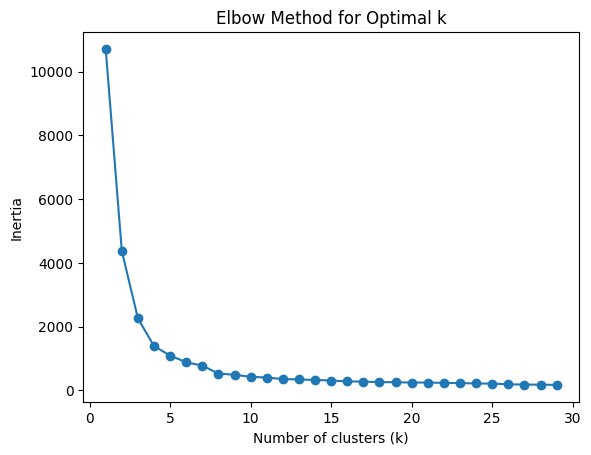

In [98]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define range for number of clusters to test
K_range = range(1, 30)

# Calculate inertia for each k in the range
inertia = [KMeans(n_clusters=k, random_state=0).fit(data_scaled_df).inertia_ for k in K_range]

# Plot the Elbow Curve
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

We see the elbow starts between 8-12.

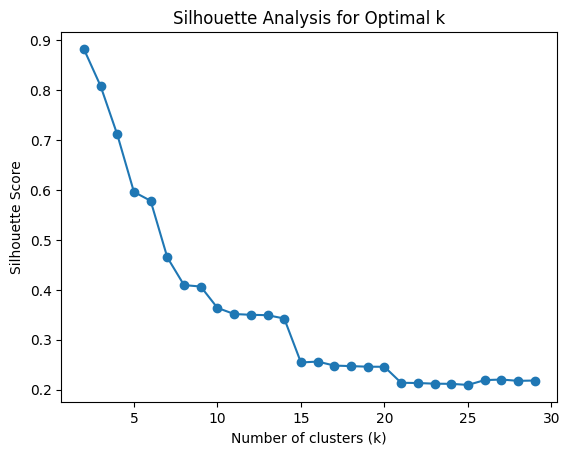

In [99]:
from sklearn.metrics import silhouette_score

# Define range for number of clusters to test
K_range = range(2, 30)

# Calculate silhouette scores for each k in the range
silhouette_scores = [
    silhouette_score(data_scaled_df, KMeans(n_clusters=k, random_state=0).fit_predict(data_scaled_df))
    for k in K_range
]

# Plot silhouette scores
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()


The silhouette analysis shows that the silhouette score declines sharply between
𝑘=3 and𝑘
=
6
, but it stabilizes somewhat around
𝑘
=
8
 to
𝑘
=
10
, supporting that
𝑘
=
10
could be a reasonable choice for clustering

In [112]:
# Fit KMeans model with the chosen number of clusters
k_optimal = 10  # Replace with the chosen optimal number of clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=0)
data_final['Cluster'] = kmeans.fit_predict(data_final)

In [113]:
# Find Dublin's cluster
Dublin_cluster = data_final[(data_final['state'] == '39') &
                                         (data_final['place'] == '22694')]['Cluster'].values[0]
print("Cluster for Dublin, Ohio:")
print(Dublin_cluster)

# Filter for rows where state is 39, which is Ohio
state_39_clusters = data_final[data_final['state'] == '39']

# Count the number of entries in each cluster for state 39
cluster_counts_state_39 = state_39_clusters['Cluster'].value_counts().sort_index()
print("\nCluster counts for Ohio:")
print(cluster_counts_state_39)

# Count the number of entries in each cluster overall
overall_cluster_counts = data_final['Cluster'].value_counts().sort_index()
print("\nOverall cluster counts:")
print(overall_cluster_counts)


Cluster for Dublin, Ohio:
0

Cluster counts for Ohio:
Cluster
0    1
1    1
3    2
5    1
6    1
7    3
9    1
Name: count, dtype: int64

Overall cluster counts:
Cluster
0    66
1    39
2    50
3    73
4    48
5    56
6    62
7    76
8    49
9    45
Name: count, dtype: int64


We find that Dublin is in Cluster 0 along with 65 other places. Through the k-means clustering, we are able to bring down the possible sister cities to 65.

### Analyze Dublin's Cluster

In [64]:
# Regions are based off of those at
# https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

# Create a dictionary to map states to divisions

states_to_division = {

    'Connecticut':'New England','Maine':'New England','Massachusetts':'New England',
    'New Hampshire':'New England','Rhode Island':'New England','Vermont':'New England',

    'New Jersey': 'Middle Atlantic', 'Pennsylvania': 'Middle Atlantic','New York'	: 'Middle Atlantic',

    'Indiana': 'East North Central','Illinois': 'East North Central' ,'Michigan': 'East North Central',
    'Ohio': 'East North Central','Wisconsin': 'East North Central',

    'Iowa'	 :'West North Central','Nebraska'	:'West North Central','Kansas' 	:'West North Central',
    'North Dakota'	:'West North Central','Minnesota'	:'West North Central' ,'South Dakota'	:'West North Central',
    'Missouri':'West North Central',

    'Delaware' :'South Atlantic', 'District of Columbia'	:'South Atlantic',
    'Florida' :'South Atlantic','Georgia' :'South Atlantic','Maryland' :'South Atlantic',
    'North Carolina' :'South Atlantic','South Carolina' :'South Atlantic',
    'Virginia' :'South Atlantic','West Virginia' :'South Atlantic',

    'Alabama': 'East South Central','Kentucky': 'East South Central',
    'Mississippi': 'East South Central','Tennessee': 'East South Central',

    'Arkansas': 'West South Central', 'Louisiana': 'West South Central',
    'Oklahoma':'West South Central','Texas':'West South Central',

    'Arizona': 'Mountain', 'Colorado': 'Mountain','Idaho': 'Mountain', 'New Mexico': 'Mountain',
    'Montana': 'Mountain', 'Utah': 'Mountain','Nevada': 'Mountain','Wyoming': 'Mountain',

    'Washington': 'Pacific', 'Oregon': 'Pacific', 'California': 'Pacific','Alaska': 'Pacific', 'Hawaii': 'Pacific'}

division_to_region = {
   'New England':'Northeast','Middle Atlantic':'Northeast',
   'East North Central': 'Midwest', 'West North Central': 'Midwest',
   'South Atlantic': 'South', 'East South Central': 'South',  'West South Central': 'South',
   'Mountain': 'West', 'Pacific': 'West'}

In [111]:
# Merge place information into data_final
filtered_census_data_df = data_final.merge(
    place_dict_df[['place', 'state', 'City Name', 'State_Name']],
    on=['place', 'state'],
    how='inner'
)

# Map states to divisions and divisions to regions
filtered_census_data_df['Division'] = filtered_census_data_df['State_Name'].map(states_to_division)
filtered_census_data_df['Region'] = filtered_census_data_df['Division'].map(division_to_region)

# Identify the target cluster for state = 39 and place = 22694
target_cluster = filtered_census_data_df[
    (filtered_census_data_df['state'] == '39') &
    (filtered_census_data_df['place'] == '22694')
]['Cluster'].values[0]

# Filter for rows with the same cluster value
cluster_subset = filtered_census_data_df[filtered_census_data_df['Cluster'] == target_cluster]

# Group by State_Name, Region, and Division, and count occurrences
grouped_counts = {
    group_by: cluster_subset.groupby(group_by).size().reset_index(name='Count')
    for group_by in ['State_Name', 'Region', 'Division']
}

# Access individual group count DataFrames
counts_by_state = grouped_counts['State_Name']
counts_by_region = grouped_counts['Region']
counts_by_division = grouped_counts['Division']

# Display the result
print("Counts by State:")
print(counts_by_state)

print("\nCounts by Division:")
print(counts_by_division)

print("\nCounts by Region:")
print(counts_by_region)

Counts by State:
        State_Name  Count
0          Alabama      1
1          Arizona      4
2         Arkansas      2
3       California     12
4         Colorado      1
5          Florida      3
6          Georgia      1
7           Hawaii      1
8         Illinois      2
9          Indiana      3
10            Iowa      1
11        Maryland      2
12   Massachusetts      3
13        Michigan      2
14        Nebraska      1
15          Nevada      1
16  North Carolina      4
17    North Dakota      1
18            Ohio      1
19        Oklahoma      1
20          Oregon      1
21       Tennessee      2
22           Texas     10
23            Utah      1
24        Virginia      1
25      Washington      2
26       Wisconsin      2

Counts by Division:
             Division  Count
0  East North Central     10
1  East South Central      3
2            Mountain      7
3         New England      3
4             Pacific     16
5      South Atlantic     11
6  West North Central      3
7 